In [3]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
from data import load_finches_2012, load_finches_1975
from utils import ECDF

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/ericmjl/anaconda/envs/bayesian-modelling-tutorial/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
df12 = load_finches_2012()
df12['shape'] = df12['beak_depth'] / df12['beak_length']

df12 = df12[df12['species'] != 'unknown']
df75 = load_finches_1975()

df = df12  # convenient alias

In [5]:
df12.head(5)

,band,species,beak_length,beak_depth,species_enc,shape
0,19022,fortis,10.0,8.5,0,0.850000
1,19028,fortis,12.5,8.9,0,0.712000
2,19032,fortis,9.3,7.5,0,0.806452
3,19041,fortis,10.3,9.6,0,0.932039
4,19044,fortis,11.0,9.2,0,0.836364


In [6]:
fortis_idx = df[df['species'] == 'fortis'].index
scandens_idx = df[df['species'] == 'scandens'].index

In [7]:
# Mega-model incorporating shape as well. 
# We will also analyze the SD in addition to the mean.

with pm.Model() as beak_model:
    # SD can only be positive, therefore it is reasonable to constrain to >0
    # Likewise for betas.
    sd_hyper = pm.HalfCauchy('sd_hyper', beta=100, shape=(2,))
    beta_hyper = pm.HalfCauchy('beta_hyper', beta=100, shape=(2,))
    
    # Beaks cannot be of "negative" mean, therefore, HalfNormal is 
    # a reasonable, constrained prior.
    mean_depth = pm.HalfNormal('mean_depth', sd=sd_hyper[0], shape=(2,))
    sd_depth = pm.HalfCauchy('sd_depth', beta=beta_hyper[0], shape=(2,))
    
    mean_length = pm.HalfNormal('mean_length', sd=sd_hyper[1], shape=(2,))
    sd_length = pm.HalfCauchy('sd_length', beta=beta_hyper[1], shape=(2,))

    nu = pm.Exponential('nu', lam=1/29.) + 1
    
    # Define the likelihood distribution for the data.
    depth = pm.StudentT('depth', 
                        nu=nu,
                        mu=mean_depth[df['species_enc']], 
                        sd=sd_depth[df['species_enc']], 
                        observed=df['beak_depth'])
    
    length = pm.StudentT('length',
                         nu=nu,
                         mu=mean_length[df['species_enc']],
                         sd=sd_length[df['species_enc']],
                         observed=df['beak_length'])
    
    shape = pm.Deterministic('shape', depth / length)

In [8]:
with beak_model:
    trace = pm.sample(2000)

100%|██████████| 2500/2500 [00:32<00:00, 76.74it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1c27cbe0>,
      dtype=object)

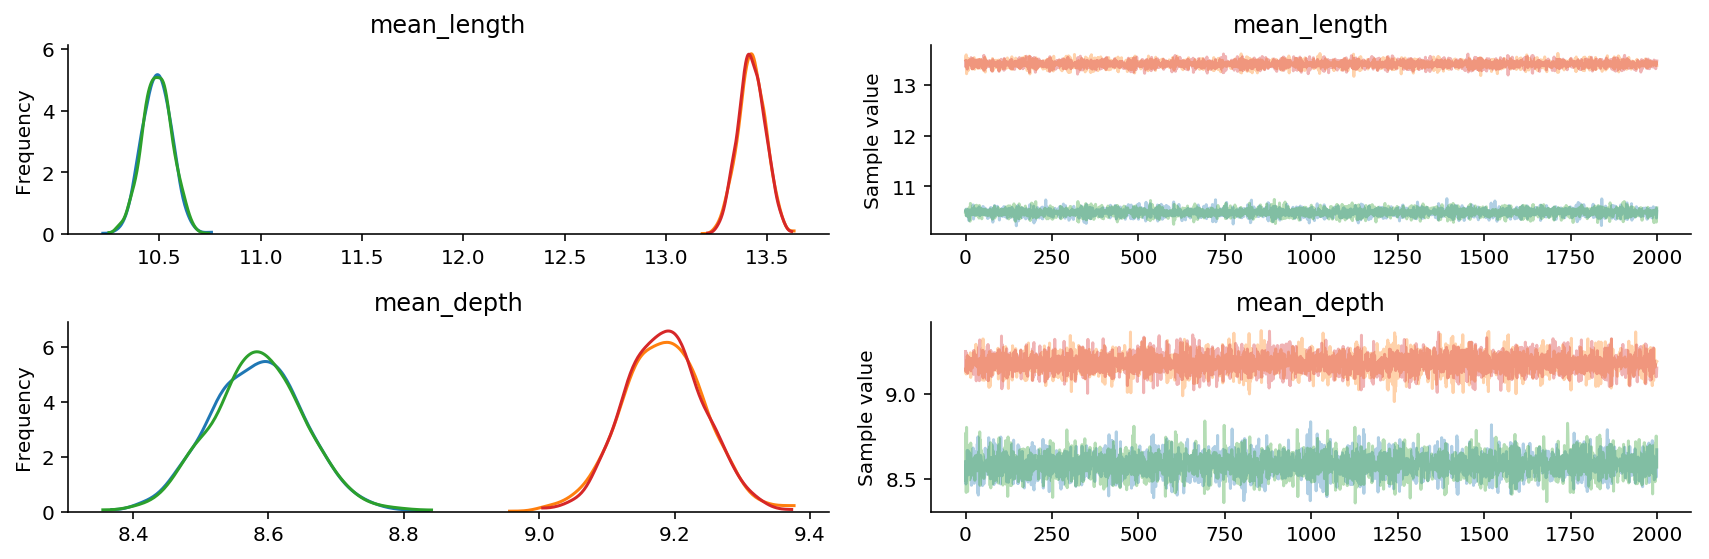

In [9]:
pm.traceplot(trace, varnames=['mean_length', 'mean_depth'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1c8e3f28>,
      dtype=object)

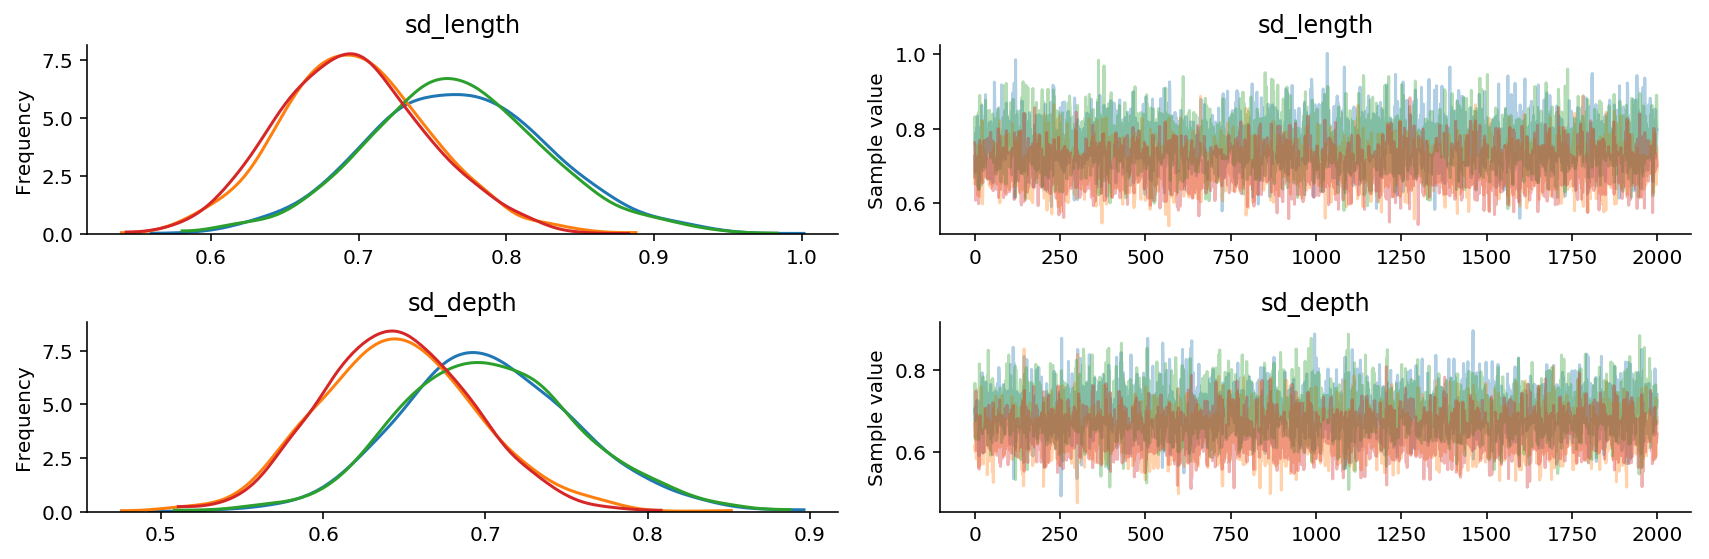

In [10]:
pm.traceplot(trace, varnames=['sd_length', 'sd_depth'])

In [11]:
samples = pm.sample_ppc(trace, model=beak_model)
samples

100%|██████████| 2000/2000 [00:02<00:00, 858.91it/s]


{'depth': array([[ 7.4023863 ,  8.07717693,  9.21663915, ...,  8.81557515,
         10.2259714 ,  8.59382726],
        [ 7.81352575,  7.62752466,  8.40302956, ...,  8.79954167,
          9.7485465 ,  9.38407132],
        [ 8.54697235,  7.9707545 ,  9.53907434, ...,  7.63213668,
          9.30160789,  8.99110449],
        ...,
        [ 8.61231322,  8.28053867,  9.44768961, ...,  9.56763697,
          9.07593097,  9.05706486],
        [ 7.81680522,  9.28541683,  9.85312268, ...,  9.72916317,
          9.60798132,  9.03838855],
        [ 8.33790803,  8.51679833,  7.96528254, ...,  9.98642404,
          9.11608826, 10.68821649]]),
 'length': array([[ 9.89955348, 10.8431942 ,  9.43047003, ..., 13.03657717,
         13.55151566, 12.41057095],
        [10.54980838, 10.52044563,  9.77787502, ..., 12.67895426,
         12.95724182, 13.40234186],
        [10.53026157,  9.33345913,  9.46459817, ..., 11.21889137,
         13.01049177, 14.29594279],
        ...,
        [ 9.90240431,  9.85739283, 

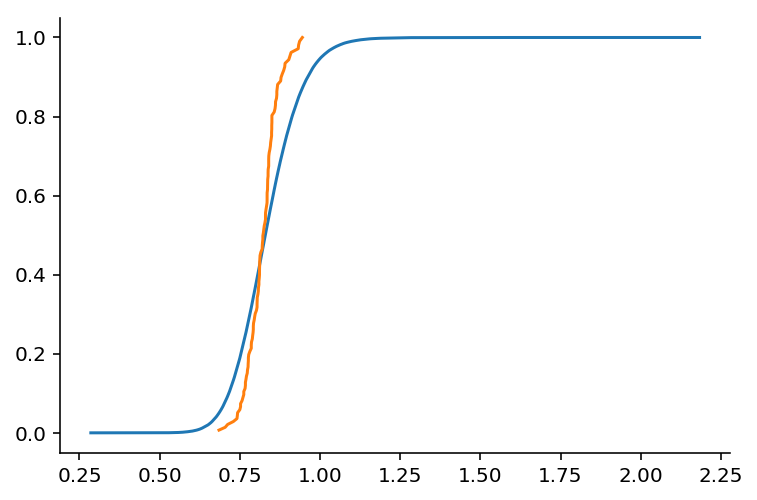

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
x, y = ECDF((samples['depth'][:, fortis_idx] / samples['length'][:, fortis_idx]).flatten())
ax.plot(x, y)
x, y = ECDF(df.loc[fortis_idx, 'shape'])
ax.plot(x, y)

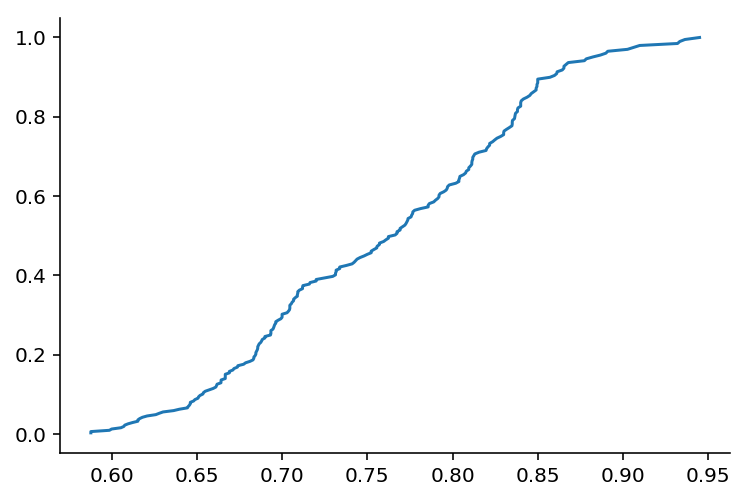

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
x, y = ECDF(df['shape'])
ax.plot(x, y, label='data')
# x, y = ECDF(trace['shape'][0, :])
# ax.plot(x, y, label='posterior')
